## Credit Card Fraud Detection

### Problem Statement - 
Predict fraudulent credit card transactions with the help of Machine learning models.

### Dataset Description - 

The data set includes credit card transactions made by European cardholders over a period of two days in September 2013. Out of a total of 2,84,807 transactions, 492 were fraudulent. This data set is highly unbalanced, with the positive class (frauds) accounting for 0.172% of the total transactions. The data set has also been modified with principal component analysis (PCA) to maintain confidentiality. Apart from ‘time’ and ‘amount’, all the other features (V1, V2, V3, up to V28) are the principal components obtained using PCA. The feature 'time' contains the seconds elapsed between the first transaction in the data set and the subsequent transactions. The feature 'amount' is the transaction amount. The feature 'class' represents class labelling, and it takes the value of 1 in cases of fraud and 0 in others.

### Project Pipeline - 
The project pipeline can be briefly summarised in the following four steps:

#### Data Understanding: 
We need to load the dataset and understand the features present in it. 

#### Exploratory Data Analysis (EDA): 
We need to check whether there is any skewness in the data and try to mitigate it, as it might cause problems during the model building phase.

#### Train/Test split: 
It is required to split the dataset into train/test set to check the performance of the models with unseen data. We need to use stratified k-fold cross-validation method. 

#### Model building / hyperparameter tuning: 
We have to try building different models and fine-tune their hyperparameters until we get the desired level of performance on the raw (imbalanced) data set. Finally, we have to build up a better model after balancing the dataset (SMOTE & ADASYN). 

#### Model evaluation: 
Evaluate the models using an appropriate evaluation metric. Note that since the data is imbalanced, it is is more important to identify the fraudulent transactions accurately than the non-fraudulent ones. We need to choose an appropriate evaluation metric that reflects this business goal.

## 1. Import necessary libraries and dataset

In [ ]:
# Installing XGBoost Package
!pip install xgboost

In [ ]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import PowerTransformer

from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import roc_auc_score, roc_curve,accuracy_score,confusion_matrix,classification_report

In [ ]:
# Loading the Dataset for further analysis
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 2. Understanding the Data

In [ ]:
# Checking the shape of the dataset
df.shape

(284807, 31)

In [ ]:
# Checking the datatype and if there's any missing values present in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

#### No missing values are present in the dataset. Hence missing value treatment/imputation is not required.

In [ ]:
#Checking data description
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Here we will observe the distribution of our classes

In [ ]:
#Observing the class distribution
classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100
print(normal_share)
print(fraud_share)

99.82725143693798
0.1727485630620034


#### It's a clear case of class imbalance. Hence, accuracy will not be a good measure to evaluate classification model performance. As majority class (Non-fraudulent) share is as high as 99.82% hence accuracy metric will ignore minority class (Fraudulent). 

## 3. Exploratory Data Analysis

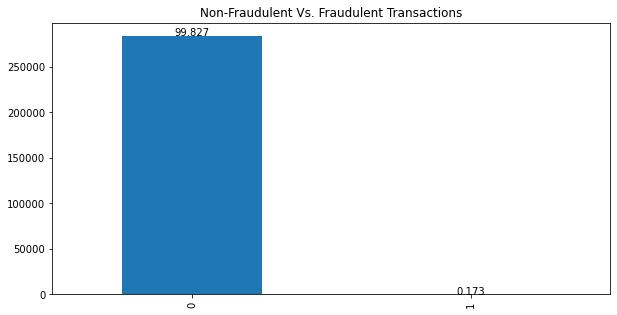

In [ ]:
# Creating Bar plot to observe the distribution of number and percentage of fraudulent vs non-fraudulent transcations
plt.figure(figsize=(10,5))
plt.title('Non-Fraudulent Vs. Fraudulent Transactions', fontweight=5,fontsize=12)
tran = df['Class'].value_counts().plot(kind='bar')
percent = (float(len(df)))/100
for i in tran.patches:
    height = i.get_height()
    tran.text(i.get_x()+i.get_width()/2.,
            height + 3,
            '{:1.3f}'.format(height/percent),
            ha="center") 

Above Bar plot depicts that non-fraudulent transactions are close to 99.827%. On the contrary, fraudulent transactions percentage is as low as 0.173%. 

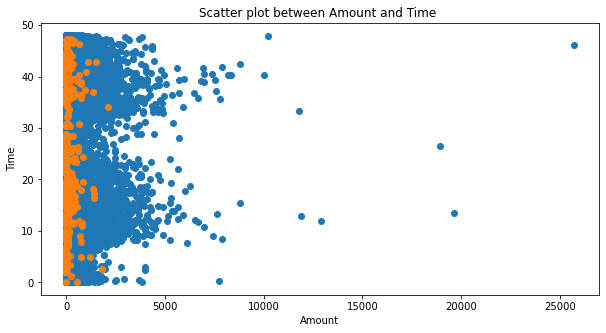

In [ ]:
# Creating scatter plot to observe the distribution of Amount and time
fig = plt.figure(figsize = (10,5))
plt.scatter(df[df.Class == 0].Amount, df[df.Class == 0].Time.values/(60*60),label='Non Fraud')
plt.scatter(df[df.Class == 1].Amount, df[df.Class == 1].Time.values/(60*60),label='Fraud')
plt.xlabel('Amount')
plt.ylabel('Time')
plt.title('Scatter plot between Amount and Time ')
plt.show()

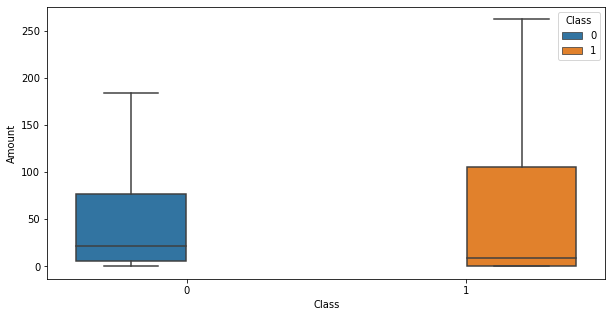

In [ ]:
# Creating Box plot to check Amount of transaction of both classes
plt.figure(figsize=(10,5))
sns.boxplot(x='Class', y='Amount', hue='Class',data=df,showfliers=False)
plt.show()

Fraudulent transaction amount is very high as compared to non-fraudulent transaction.

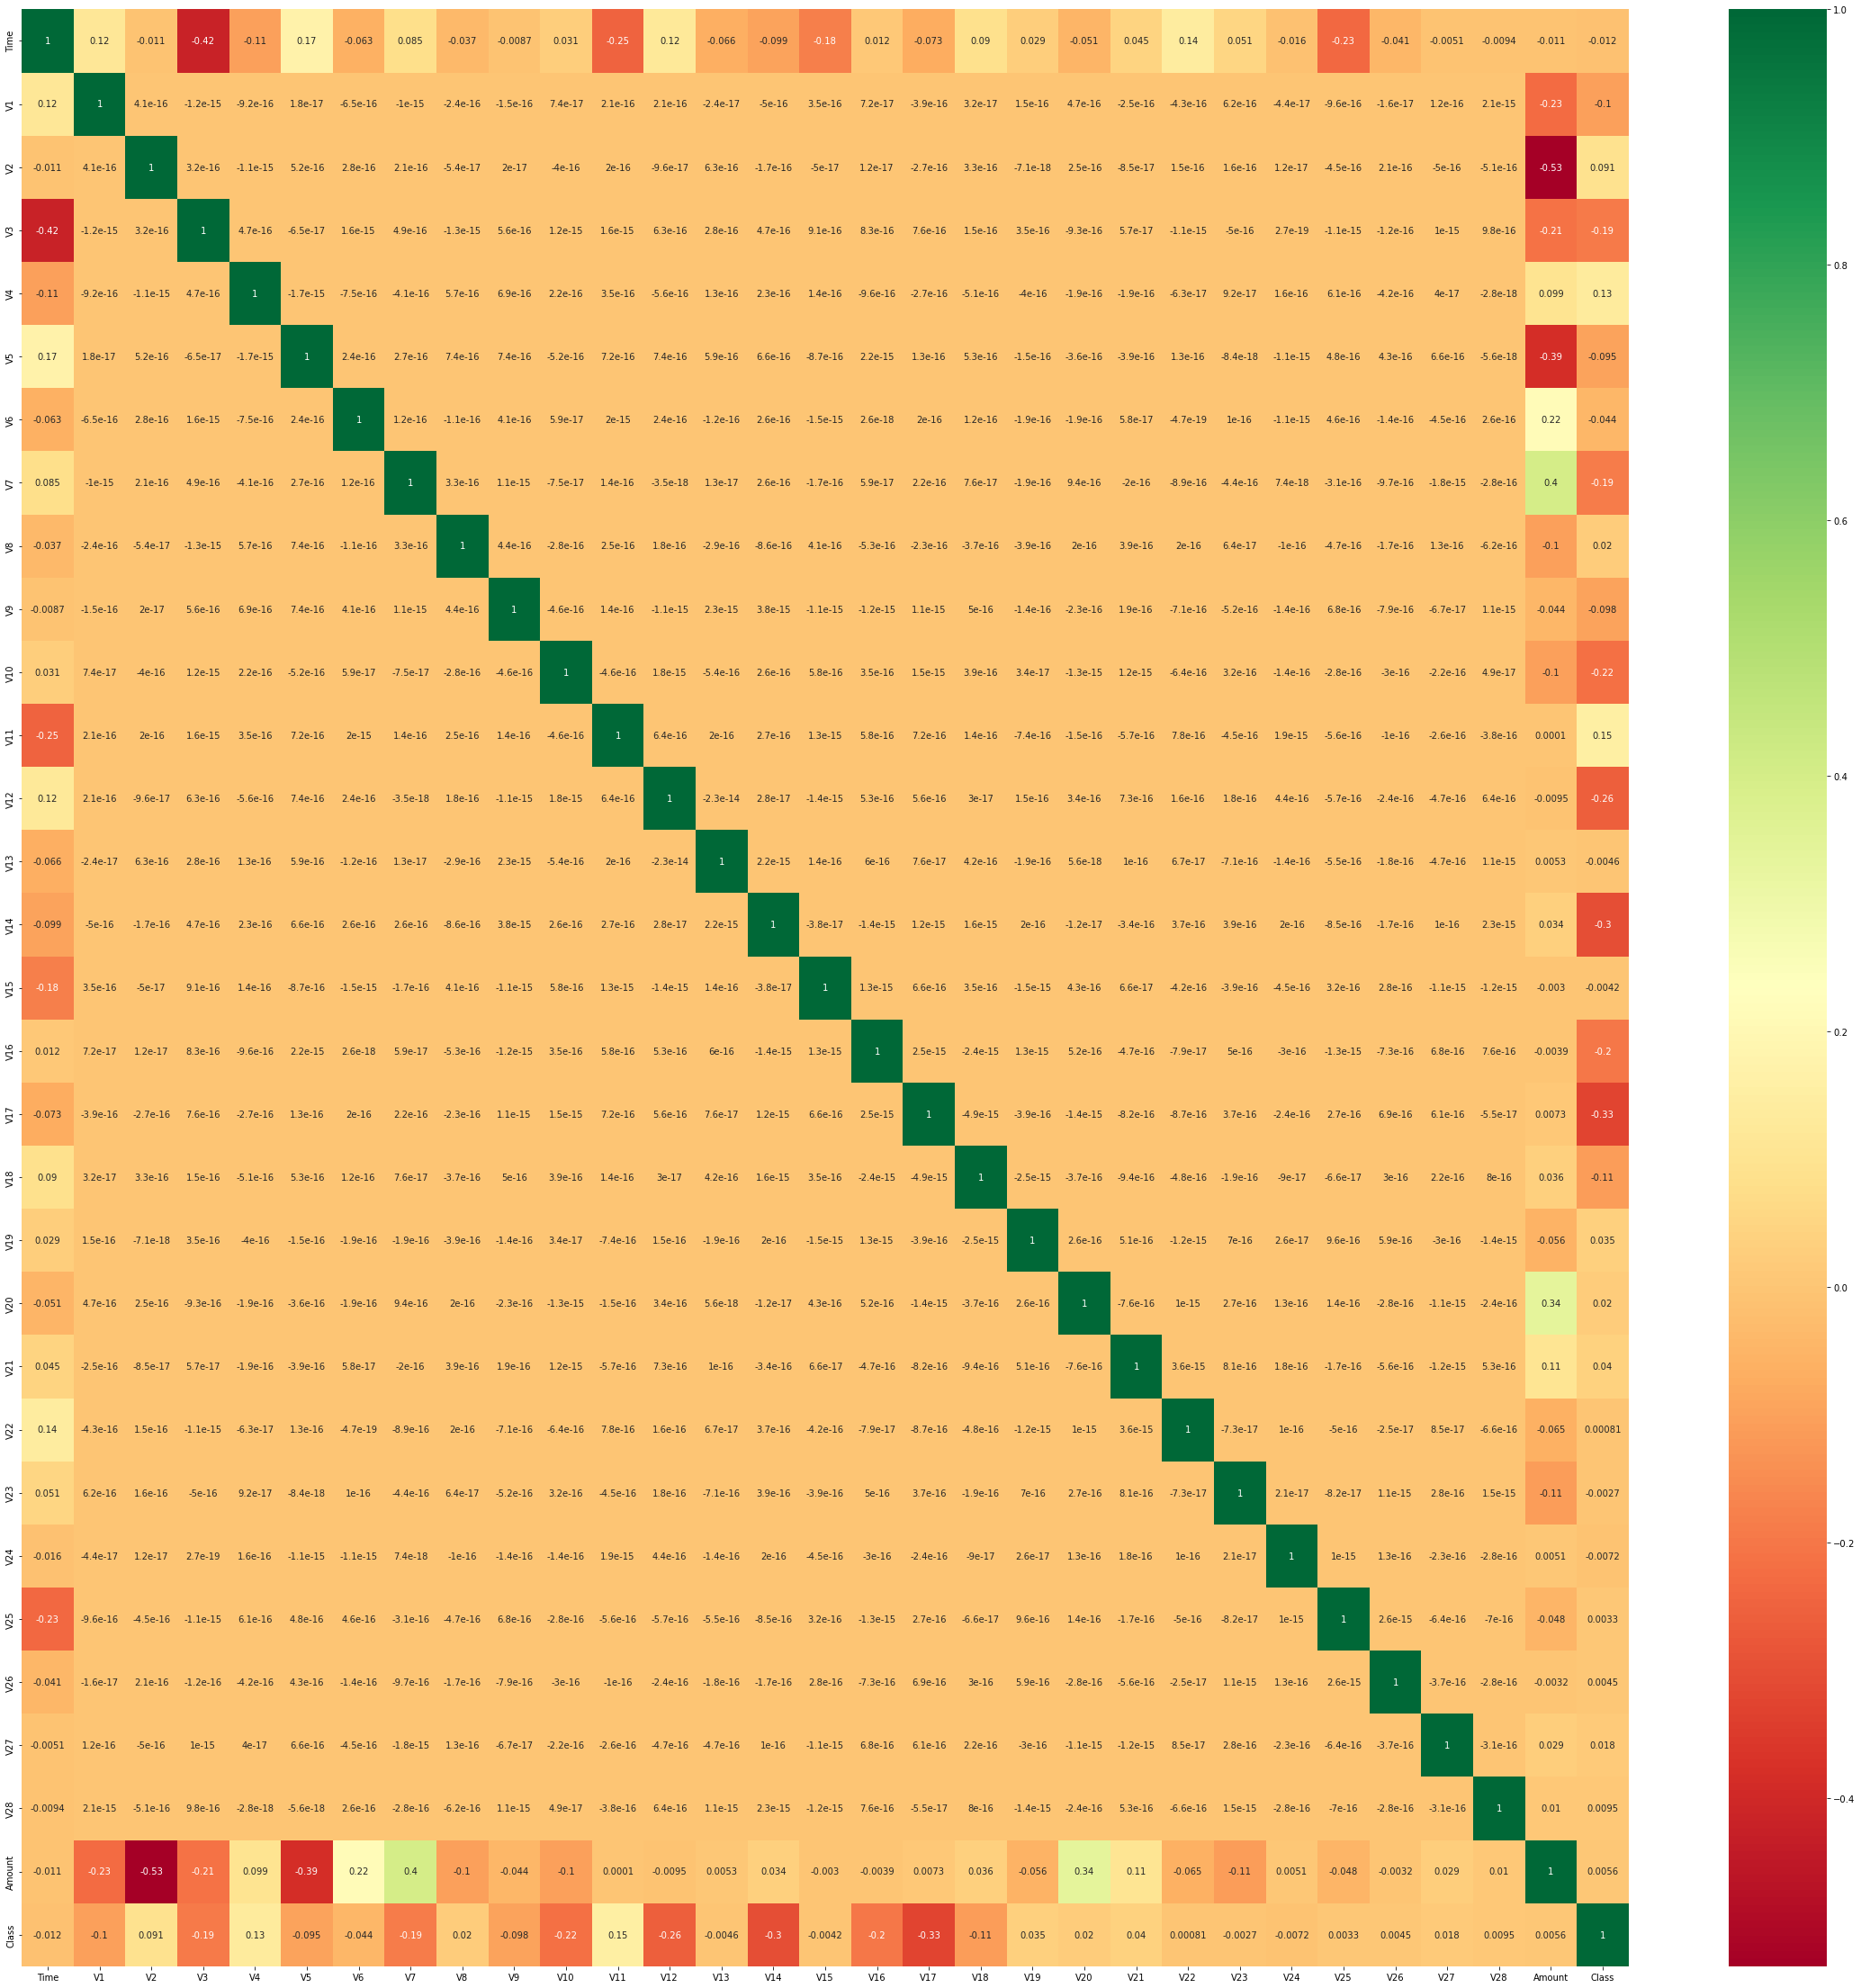

In [ ]:
# Plotting heatmap to observe multicollinearity among variables
plt.figure(figsize=[40,40])
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn')
plt.show()

Above Heatmap depicts that multicollineraity doesn't exist between the variables.

In [ ]:
# Drop unnecessary columns
# As Time feature has no impact on the dataset hence we are dropping Time column
df.drop(['Time'], axis=1, inplace=True)

In [ ]:
# Checking the shape of dataset after dropping Time feature
df.shape

(284807, 30)

### 4. Splitting the data into train & test data

In [ ]:
#Putting the Target variable into y
y= df['Class']

In [ ]:
#Putting the other features into X
X = df.drop(['Class'], axis=1)
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [ ]:
#Splitting the dataset into Train & Test set
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,random_state=42,stratify=y)

In [ ]:
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
344
148


### Plotting the distribution of a variable

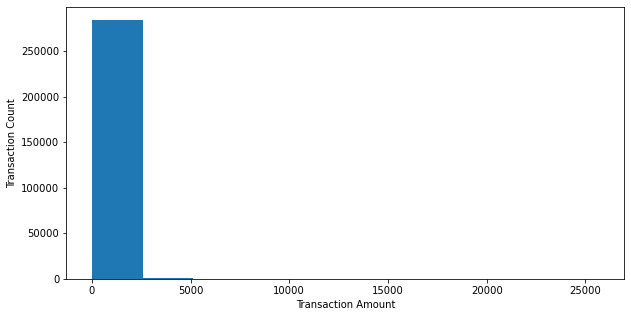

In [ ]:
# Plotting the histogram of Amount variable to see the skewness
plt.figure(figsize=[10,5])
plt.hist(df['Amount'])
plt.xlabel('Transaction Amount')
plt.ylabel('Transaction Count')
plt.show()

Above Histogram depicts that Amount variable is Right-Skewed. 

### As skewness is present in the distribution we have used:
- <b>Power Transformer</b> package present in the <b>preprocessing library provided by sklearn</b> to make distribution more gaussian

In [ ]:
#Applying PowerTransformer to fit & transform the train & test data
power_transformer = PowerTransformer(copy=False)
pt_X = power_transformer.fit_transform(X)

In [ ]:
# Splitting the data into Train & Test in 70:30 ratio after applying Power Transformer

kfold=5
sss = StratifiedShuffleSplit(n_splits=kfold, train_size=0.7, random_state=42)
for train_index, test_index in sss.split(pt_X, y):
        X_train, X_test = pt_X[train_index], pt_X[test_index]
        y_train, y_test = y[train_index], y[test_index]

## 5. Model Building

#### Model 1 - Logistic Regression
#### Logistic Regression on imbalanced data

In [ ]:
#Fit a Logistic Regression Model to train data
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression()

In [ ]:
# Predict on the test data
y_predict = logreg.predict(X_test)

In [ ]:
#Evaluation metrics
print('Classification report of Logistic Regression:\n', classification_report(y_test, y_predict))
print("Test Accuracy of Logistic Regression: ",accuracy_score(y_test,y_predict))
print("ROC AUC Score of Logistic Regression:", roc_auc_score(y_test,y_predict))

Classification report of Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.88      0.62      0.73       148

    accuracy                           1.00     85443
   macro avg       0.94      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443

Test Accuracy of Logistic Regression:  0.9991924440855307
ROC AUC Score of Logistic Regression: 0.8107346047025981


#### Logistic Regression on imbalanced data with Hyperparameter Tuning

In [ ]:
#Applying 5 fold cross-validation
n_fold = 5
params = {'C': [0.1,0.5,1,2,5,10,20],
          'penalty': ['l1', 'l2']
         }
logregh = LogisticRegression()
model_logregh = GridSearchCV(estimator=logregh, param_grid=params, scoring='roc_auc', n_jobs=-1, cv=n_fold, verbose=1)

In [ ]:
#Fitting the Model to train data
model_logregh.fit(X_train,y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 2, 5, 10, 20],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [ ]:
#Printing best hyperparameters
print("Best hyperparameter for Logistic Regression are:", model_logregh.best_params_)

Best hyperparameter for Logistic Regression are: {'C': 0.1, 'penalty': 'l2'}


In [ ]:
#Passing the best hyperparameters
model_logreg_tuned = LogisticRegression(C=0.1,penalty='l2')

In [ ]:
#Predicting on test data
model_logreg_tuned.fit(X_train,y_train)
y_predict = model_logreg_tuned.predict(X_test)

In [ ]:
#Evaluation metrics
print('Classification report of Logistic Regression after hyperparameter tuning:\n', classification_report(y_test, y_predict))
print("Test Accuracy of Logistic Regression after hyperparameter tuning: ",accuracy_score(y_test,y_predict))
print("ROC AUC Score of Logistic Regression after hyperparameter tuning:", roc_auc_score(y_test,y_predict))

Classification report of Logistic Regression after hyperparameter tuning:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.88      0.61      0.72       148

    accuracy                           1.00     85443
   macro avg       0.94      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443

Test Accuracy of Logistic Regression after hyperparameter tuning:  0.9991807403766253
ROC AUC Score of Logistic Regression after hyperparameter tuning: 0.8073562263242198


#### Model 2 - Decision Tree
#### Decision Tree on imbalanced data

In [ ]:
#Initializing a Decision Tree Model
dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_features='sqrt', random_state=42)

In [ ]:
#Fit a Decision Tree Model to train data
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_features='sqrt', random_state=42)

In [ ]:
# Predict on the test data
y_predict = dt.predict(X_test)

In [ ]:
#Evaluation metrics
print('Classification report of Decision Tree:\n', classification_report(y_test, y_predict))
print("Test Accuracy of Decision Tree: ",accuracy_score(y_test,y_predict))
print("ROC AUC Score of Decision Tree:", roc_auc_score(y_test,y_predict))

Classification report of Decision Tree:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.73      0.72      0.73       148

    accuracy                           1.00     85443
   macro avg       0.86      0.86      0.86     85443
weighted avg       1.00      1.00      1.00     85443

Test Accuracy of Decision Tree:  0.9990519995786665
ROC AUC Score of Decision Tree: 0.8612520061535245


#### Decision Tree on imbalanced data with Hyperparameter Tuning

In [ ]:
#Defining parameter grid
params = {'max_depth': [4,7,10],
          'min_samples_split': [5,7,10],
          'min_samples_leaf': [3,6,8]
         }

In [ ]:
# Stratified K Fold
cross_val = StratifiedKFold(n_splits=5)
index_iterator = cross_val.split(X_train, y_train)
dth = DecisionTreeClassifier()
model_dth = RandomizedSearchCV(estimator=dth, param_distributions=params, scoring='roc_auc', cv=cross_val, verbose=1, random_state=42)

In [ ]:
#Fitting the model to train data
model_dth.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(),
                   param_distributions={'max_depth': [4, 7, 10],
                                        'min_samples_leaf': [3, 6, 8],
                                        'min_samples_split': [5, 7, 10]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [ ]:
#Printing the best hyperparameters
print("Best hyperparameter for Decision Tree are:", model_dth.best_params_)

Best hyperparameter for Decision Tree are: {'min_samples_split': 5, 'min_samples_leaf': 6, 'max_depth': 10}


In [ ]:
#Passing the best hyperparameters
model_dth_tuned = DecisionTreeClassifier(max_depth=10,max_features='sqrt',criterion='gini',min_samples_split=5, min_samples_leaf=6,random_state=42,splitter='best')

In [ ]:
#Fitting the model on train data
model_dth_tuned.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=6,
                       min_samples_split=5, random_state=42)

In [ ]:
#Predicting on test data
y_predict=model_dth_tuned.predict(X_test)

In [ ]:
#Evaluation metrics
print('Classification report of Decision Tree after hyperparameter tuning:\n', classification_report(y_test, y_predict))
print("Test Accuracy of Decision Tree after hyperparameter tuning: ",accuracy_score(y_test,y_predict))
print("ROC AUC Score of Decision Tree after hyperparameter tuning:", roc_auc_score(y_test,y_predict))

Classification report of Decision Tree after hyperparameter tuning:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.88      0.64      0.74       148

    accuracy                           1.00     85443
   macro avg       0.94      0.82      0.87     85443
weighted avg       1.00      1.00      1.00     85443

Test Accuracy of Decision Tree after hyperparameter tuning:  0.9992158515033414
ROC AUC Score of Decision Tree after hyperparameter tuning: 0.8174913614593549


#### Model 3 - Random Forest
#### Random Forest on imbalanced data

In [ ]:
#Initializing a Random Forest Model
rf = RandomForestClassifier(n_estimators=10,criterion='gini', random_state=42, max_features='sqrt', bootstrap=True, oob_score=False, n_jobs=-1, verbose=1)

In [ ]:
#Fit a Random Forest Model to train data
rf.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.7s finished


RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42, verbose=1)

In [ ]:
# Predict on the test data
y_predict = rf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


In [ ]:
#Evaluation metrics
print('Classification report of Random Forest:\n', classification_report(y_test, y_predict))
print("Test Accuracy of Random Forest: ",accuracy_score(y_test,y_predict))
print("ROC AUC Score of Random Forest:", roc_auc_score(y_test,y_predict))

Classification report of Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.88      0.71      0.79       148

    accuracy                           1.00     85443
   macro avg       0.94      0.85      0.89     85443
weighted avg       1.00      1.00      1.00     85443

Test Accuracy of Random Forest:  0.9993328885923949
ROC AUC Score of Random Forest: 0.854647661613193


#### Random Forest on imbalanced data with Hyperparameter Tuning

In [ ]:
#Defining parameter grid
params = {'max_depth': [1,3,5],
          'min_samples_split': [2,4,6],
          'min_samples_leaf': [1,3,5],
          'max_features': ['sqrt','log2']
         }

In [ ]:
# Stratified K Fold
cross_val = StratifiedKFold(n_splits=5)
index_iterator = cross_val.split(X_train, y_train)
rfh = RandomForestClassifier()
model_rfh = RandomizedSearchCV(estimator=rfh, param_distributions=params, scoring='roc_auc', n_jobs=-1, cv=cross_val, verbose=1, random_state=42)

In [ ]:
#Fitting the model to train data
model_rfh.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [1, 3, 5],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 3, 5],
                                        'min_samples_split': [2, 4, 6]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [ ]:
#Printing the best hyperparameters
print("Best hyperparameter for Random Forest are:", model_rfh.best_params_)

Best hyperparameter for Random Forest are: {'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 5}


In [ ]:
#Passing the best hyperparameters
model_rfh_tuned = RandomForestClassifier(max_depth=5,n_estimators=100,min_samples_split=2,min_samples_leaf=3,max_features='log2',criterion='gini', random_state=42, bootstrap=True, oob_score=False, n_jobs=-1, verbose=1)

In [ ]:
#Fitting the model on train data
model_rfh_tuned.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.1s finished


RandomForestClassifier(max_depth=5, max_features='log2', min_samples_leaf=3,
                       n_jobs=-1, random_state=42, verbose=1)

In [ ]:
#Predicting on test data
y_predict=model_rfh_tuned.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
#Evaluation metrics
print('Classification report of Random Forest after hyperparameter tuning:\n', classification_report(y_test, y_predict))
print("Test Accuracy of Random Forest after hyperparameter tuning: ",accuracy_score(y_test,y_predict))
print("ROC AUC Score of Random Forest after hyperparameter tuning:", roc_auc_score(y_test,y_predict))

Classification report of Random Forest after hyperparameter tuning:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.88      0.67      0.76       148

    accuracy                           1.00     85443
   macro avg       0.94      0.83      0.88     85443
weighted avg       1.00      1.00      1.00     85443

Test Accuracy of Random Forest after hyperparameter tuning:  0.9992743700478681
ROC AUC Score of Random Forest after hyperparameter tuning: 0.8343832533512467


#### Model 4 - XGBoost
#### XGBoost on imbalanced data

In [ ]:
#Initializing XGBoost Model
xgb_model = XGBClassifier()

In [ ]:
#Fit XGBoost Model to train data
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
#Predict on test data
y_predict = xgb_model.predict(X_test)

In [ ]:
#Evaluation metrics
print('Classification report of XGBoost:\n', classification_report(y_test, y_predict))
print("Test Accuracy of XGBoost: ",accuracy_score(y_test,y_predict))
print("ROC AUC Score of XGBoost:", roc_auc_score(y_test,y_predict))

Classification report of XGBoost:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.93      0.76      0.84       148

    accuracy                           1.00     85443
   macro avg       0.97      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443

Test Accuracy of XGBoost:  0.9994850368081645
ROC AUC Score of XGBoost: 0.878331482311786


#### XGBoost on imbalanced data with Hyperparameter Tuning

In [ ]:
#Defining parameter grid
params = {'max_depth': [1,3,5],
          'subsample': [0.2,0.5,1],
          'min_child_weight': [1,3,5],
          'gamma': [1,2,5]
          }

In [ ]:
# Stratified K Fold
cross_val = StratifiedKFold(n_splits=5)
index_iterator = cross_val.split(X_train, y_train)
xgbh = XGBClassifier()
model_xgbh = RandomizedSearchCV(estimator=xgbh, param_distributions=params, scoring='roc_auc', n_jobs=-1, cv=cross_val, verbose=1, random_state=42)

In [ ]:
#Fitting the model to train data
model_xgbh.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           impor...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'gamma': [1, 2, 5],
                                        'max_depth': [1, 3, 5],
                                        'min_child_weight': [1, 3, 5],
                                        'subsample': [0.2, 0.5, 1]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [ ]:
#Printing best hyperparameters
print("Best hyperparameter for XGBoost are:", model_xgbh.best_params_)

Best hyperparameter for XGBoost are: {'subsample': 0.5, 'min_child_weight': 5, 'max_depth': 3, 'gamma': 5}


In [ ]:
#Passing the best hyperparameters
model_xgbh_tuned = XGBClassifier(max_depth=3,subsample=0.5,learning_rate=0.1,min_child_weight=5, gamma=5,n_estimators=100, booster='gbtree',random_state=42, n_jobs=-1, verbose=1)

In [ ]:
#Fitting the model on train data
model_xgbh_tuned.fit(X_train,y_train)

[15:08:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.



XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
#Predicting on test data
y_predict=model_xgbh_tuned.predict(X_test)

In [ ]:
#Evaluation metrics
print('Classification report of XGBoost after hyperparameter tuning:\n', classification_report(y_test, y_predict))
print("Test Accuracy of XGBoost after hyperparameter tuning: ",accuracy_score(y_test,y_predict))
print("ROC AUC Score of XGBoost after hyperparameter tuning:", roc_auc_score(y_test,y_predict))

Classification report of XGBoost after hyperparameter tuning:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.87      0.75      0.80       148

    accuracy                           1.00     85443
   macro avg       0.93      0.87      0.90     85443
weighted avg       1.00      1.00      1.00     85443

Test Accuracy of XGBoost after hyperparameter tuning:  0.9993679997191109
ROC AUC Score of XGBoost after hyperparameter tuning: 0.8749003458584912


## 6. Balancing the Dataset

In [ ]:
#Installing imbalanced-learn package
!pip install imbalanced-learn

In [ ]:
#Initializing SMOTE & ADASYN oversampling techniques
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)

In [ ]:
#Resample training data after applying SMOTE
X_train_smote,y_train_smote = smote.fit_resample(X_train,y_train)

In [ ]:
#Resample training data after applying ADASYN
X_train_adasyn,y_train_adasyn = adasyn.fit_resample(X_train,y_train)

## 7. Model Building on Balanced Data

#### Logistic Regression on SMOTE Balanced Data

In [ ]:
#Initializing Logistic Regression model and fitting SMOTE data to train set
logreg_smote = LogisticRegression(C=0.1,penalty='l2')
logreg_smote.fit(X_train_smote,y_train_smote)

LogisticRegression(C=0.1)

In [ ]:
# Predict on the test data
y_predict = logreg_smote.predict(X_test)

In [ ]:
#Evaluation metrics
print('Classification report of Logistic Regression on SMOTE balanced data:\n', classification_report(y_test, y_predict))
print("Test Accuracy of Logistic Regression on SMOTE balanced data: ",accuracy_score(y_test,y_predict))
print("ROC AUC Score of Logistic Regression on SMOTE balanced data:", roc_auc_score(y_test,y_predict))

Classification report of Logistic Regression on SMOTE balanced data:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.05      0.89      0.10       148

    accuracy                           0.97     85443
   macro avg       0.53      0.93      0.54     85443
weighted avg       1.00      0.97      0.98     85443

Test Accuracy of Logistic Regression on SMOTE balanced data:  0.9721919876408834
ROC AUC Score of Logistic Regression on SMOTE balanced data: 0.9287390899311293


#### Logistic Regression on ADASYN Balanced Data

In [ ]:
#Initializing Logistic Regression model and fitting ADASYN data to train set
logreg_adasyn = LogisticRegression(C=0.1,penalty='l2')
logreg_adasyn.fit(X_train_adasyn,y_train_adasyn)

LogisticRegression(C=0.1)

In [ ]:
# Predict on the test data
y_predict = logreg_adasyn.predict(X_test)

In [ ]:
#Evaluation metrics
print('Classification report of Logistic Regression on ADASYN balanced data:\n', classification_report(y_test, y_predict))
print("Test Accuracy of Logistic Regression on ADASYN balanced data: ",accuracy_score(y_test,y_predict))
print("ROC AUC Score of Logistic Regression on ADASYN balanced data:", roc_auc_score(y_test,y_predict))

Classification report of Logistic Regression on ADASYN balanced data:
               precision    recall  f1-score   support

           0       1.00      0.91      0.96     85295
           1       0.02      0.93      0.04       148

    accuracy                           0.91     85443
   macro avg       0.51      0.92      0.50     85443
weighted avg       1.00      0.91      0.95     85443

Test Accuracy of Logistic Regression on ADASYN balanced data:  0.9145395175731189
ROC AUC Score of Logistic Regression on ADASYN balanced data: 0.9234704515172304


#### Decision Tree on SMOTE Balanced Data

In [ ]:
#Initializing a Decision Tree Model
dt_smote = DecisionTreeClassifier(max_depth=10,max_features='sqrt',criterion='gini',min_samples_split=5, min_samples_leaf=6,random_state=42,splitter='best')

In [ ]:
#Fitting SMOTE data to train set
dt_smote.fit(X_train_smote,y_train_smote)

DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=6,
                       min_samples_split=5, random_state=42)

In [ ]:
#Predict on test data
y_predict = dt_smote.predict(X_test)

In [ ]:
#Evaluation metrics
print('Classification report of Decision Tree on SMOTE Balanced data:\n', classification_report(y_test, y_predict))
print("Test Accuracy of Decision Tree on SMOTE Balanced data: ",accuracy_score(y_test,y_predict))
print("ROC AUC Score of Decision Tree on SMOTE Balanced data:", roc_auc_score(y_test,y_predict))

Classification report of Decision Tree on SMOTE Balanced data:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.05      0.82      0.09       148

    accuracy                           0.97     85443
   macro avg       0.52      0.90      0.54     85443
weighted avg       1.00      0.97      0.98     85443

Test Accuracy of Decision Tree on SMOTE Balanced data:  0.9712322835106445
ROC AUC Score of Decision Tree on SMOTE Balanced data: 0.8979057579180681


#### Decision Tree on ADASYN Balanced Data

In [ ]:
#Initializing a Decision Tree Model
dt_adasyn = DecisionTreeClassifier(max_depth=10,max_features='sqrt',criterion='gini',min_samples_split=5, min_samples_leaf=8,random_state=42,splitter='best')

In [ ]:
#Fitting ADASYN data to train set
dt_adasyn.fit(X_train_adasyn,y_train_adasyn)

DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=8,
                       min_samples_split=5, random_state=42)

In [ ]:
#Predict on test data
y_predict = dt_adasyn.predict(X_test)

In [ ]:
#Evaluation metrics
print('Classification report of Decision Tree on ADASYN Balanced data:\n', classification_report(y_test, y_predict))
print("Test Accuracy of Decision Tree on ADASYN Balanced data: ",accuracy_score(y_test,y_predict))
print("ROC AUC Score of Decision Tree on ADASYN Balanced data:", roc_auc_score(y_test,y_predict))

Classification report of Decision Tree on ADASYN Balanced data:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98     85295
           1       0.03      0.82      0.06       148

    accuracy                           0.95     85443
   macro avg       0.51      0.88      0.52     85443
weighted avg       1.00      0.95      0.97     85443

Test Accuracy of Decision Tree on ADASYN Balanced data:  0.9517104970565172
ROC AUC Score of Decision Tree on ADASYN Balanced data: 0.8847554116634954


#### Random Forest on SMOTE Balanced Data

In [ ]:
#Initializing Random Forest model
rf_smote = RandomForestClassifier(max_depth=5,n_estimators=100,min_samples_split=2,min_samples_leaf=3,max_features='log2',criterion='gini', random_state=42, bootstrap=True, oob_score=False, n_jobs=-1, verbose=1)

In [ ]:
#Fitting SMOTE data to train set
rf_smote.fit(X_train_smote,y_train_smote)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.0s finished


RandomForestClassifier(max_depth=5, max_features='log2', min_samples_leaf=3,
                       n_jobs=-1, random_state=42, verbose=1)

In [ ]:
#Predict on test data
y_predict = rf_smote.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
#Evaluation metrics
print('Classification report of Random Forest on SMOTE Balanced data:\n', classification_report(y_test, y_predict))
print("Test Accuracy of Random Forest on SMOTE Balanced data: ",accuracy_score(y_test,y_predict))
print("ROC AUC Score of Random Forest on SMOTE Balanced data:", roc_auc_score(y_test,y_predict))

Classification report of Random Forest on SMOTE Balanced data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.24      0.83      0.37       148

    accuracy                           1.00     85443
   macro avg       0.62      0.91      0.68     85443
weighted avg       1.00      1.00      1.00     85443

Test Accuracy of Random Forest on SMOTE Balanced data:  0.9950961459686575
ROC AUC Score of Random Forest on SMOTE Balanced data: 0.9132309092608641


#### Random Forest on ADASYN Balanced Data

In [ ]:
#Initializing Random Forest model
rf_adasyn = RandomForestClassifier(max_depth=5,n_estimators=100,min_samples_split=2,min_samples_leaf=3,max_features='log2',criterion='gini', random_state=42, bootstrap=True, oob_score=False, n_jobs=-1, verbose=1)

In [ ]:
#Fitting ADASYN data to train set
rf_adasyn.fit(X_train_adasyn,y_train_adasyn)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.8s finished


RandomForestClassifier(max_depth=5, max_features='log2', min_samples_leaf=3,
                       n_jobs=-1, random_state=42, verbose=1)

In [ ]:
#Predict on test data
y_predict = rf_adasyn.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
#Evaluation metrics
print('Classification report of Random Forest on ADASYN Balanced data:\n', classification_report(y_test, y_predict))
print("Test Accuracy of Random Forest on ADASYN Balanced data: ",accuracy_score(y_test,y_predict))
print("ROC AUC Score of Random Forest on ADASYN Balanced data:", roc_auc_score(y_test,y_predict))

Classification report of Random Forest on ADASYN Balanced data:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     85295
           1       0.04      0.89      0.07       148

    accuracy                           0.96     85443
   macro avg       0.52      0.93      0.53     85443
weighted avg       1.00      0.96      0.98     85443

Test Accuracy of Random Forest on ADASYN Balanced data:  0.9609564270917453
ROC AUC Score of Random Forest on ADASYN Balanced data: 0.9264840783100939


#### XGBoost on SMOTE Balanced Data

In [ ]:
#Initializing XGBoost Model
xgb_model_smote = XGBClassifier(max_depth=3,subsample=0.5,learning_rate=0.1,min_child_weight=5, gamma=5,n_estimators=100, booster='gbtree',random_state=42, n_jobs=-1, verbose=1)

In [ ]:
#Fitting SMOTE data to train set
xgb_model_smote.fit(X_train_smote,y_train_smote)

[15:13:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.



XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
#Predict on test data
y_predict = xgb_model_smote.predict(X_test)

In [ ]:
#Evaluation metrics
print('Classification report of XGBoost on SMOTE balanced data:\n', classification_report(y_test, y_predict))
print("Test Accuracy of XGBoost on SMOTE balanced data: ",accuracy_score(y_test,y_predict))
print("ROC AUC Score of XGBoost on SMOTE balanced data:", roc_auc_score(y_test,y_predict))

Classification report of XGBoost on SMOTE balanced data:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     85295
           1       0.12      0.86      0.21       148

    accuracy                           0.99     85443
   macro avg       0.56      0.93      0.60     85443
weighted avg       1.00      0.99      0.99     85443

Test Accuracy of XGBoost on SMOTE balanced data:  0.9885888838172817
ROC AUC Score of XGBoost on SMOTE balanced data: 0.926834214482963


#### XGBoost on SMOTE Balanced Data with Hyperparameter tuning

In [ ]:
#Defining parameter grid
params = {'max_depth': [3,5,7],
          'subsample': [0.8,0.9],
          'gamma': [8,10,12]
          }

In [ ]:
# Stratified K Fold
cross_val = StratifiedKFold(n_splits=5)
index_iterator = cross_val.split(X_train_smote, y_train_smote)
xgbh = XGBClassifier()
model_xgbh = RandomizedSearchCV(estimator=xgbh, param_distributions=params, scoring='roc_auc', n_jobs=-1, cv=cross_val, verbose=1, random_state=42)

In [ ]:
#Fit the model on train data
model_xgbh.fit(X_train_smote,y_train_smote)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           impor...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'gamma': [8, 10, 12],
                                        'max_depth': [3, 5, 7],
                                        'subsample': [0.8, 0.9]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [ ]:
#Printing the best hyperparameter on SMOTE balanced data
print("Best hyperparameter for XGBoost on SMOTE balanced data are:", model_xgbh.best_params_)

Best hyperparameter for XGBoost on SMOTE balanced data are: {'subsample': 0.8, 'max_depth': 5, 'gamma': 10}


In [ ]:
#Passing the best hyperparameters
model_xgbh_tuned_smote = XGBClassifier(max_depth=5,subsample=0.8,learning_rate=0.1,min_child_weight=2, gamma=10,n_estimators=100, booster='gbtree',random_state=42, n_jobs=-1, verbose=1)

In [ ]:
#Fit the model on train data
model_xgbh_tuned_smote.fit(X_train_smote,y_train_smote)

[15:53:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.



XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=10, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
#Predict on test data
y_predict=model_xgbh_tuned_smote.predict(X_test)

In [ ]:
#Evaluation metrics
print('Classification report of XGBoost on SMOTE Balanced data after hyperparameter tuning:\n', classification_report(y_test, y_predict))
print("Test Accuracy of XGBoost on SMOTE Balanced data after hyperparameter tuning: ",accuracy_score(y_test,y_predict))
print("ROC AUC Score of XGBoost on SMOTE Balanced data after hyperparameter tuning:", roc_auc_score(y_test,y_predict))

Classification report of XGBoost on SMOTE Balanced data after hyperparameter tuning:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.26      0.84      0.40       148

    accuracy                           1.00     85443
   macro avg       0.63      0.92      0.70     85443
weighted avg       1.00      1.00      1.00     85443

Test Accuracy of XGBoost on SMOTE Balanced data after hyperparameter tuning:  0.9956462202872091
ROC AUC Score of XGBoost on SMOTE Balanced data after hyperparameter tuning: 0.9202514563922033


#### XGBoost on ADASYN Balanced Data

In [ ]:
#Initializing XGBoost Model
xgb_model_adasyn = XGBClassifier(max_depth=3,subsample=0.5,learning_rate=0.1,min_child_weight=5, gamma=5,n_estimators=100, booster='gbtree',random_state=42, n_jobs=-1, verbose=1)

In [ ]:
#Fitting ADASYN data to train set
xgb_model_adasyn.fit(X_train_adasyn,y_train_adasyn)

[15:56:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.



XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
#Predict to test set
y_predict = xgb_model_adasyn.predict(X_test)

In [ ]:
#Evaluation metrics
print('Classification report of XGBoost on ADASYN balanced data:\n', classification_report(y_test, y_predict))
print("Test Accuracy of XGBoost on ADASYN balanced data: ",accuracy_score(y_test,y_predict))
print("ROC AUC Score of XGBoost on ADASYN balanced data:", roc_auc_score(y_test,y_predict))

Classification report of XGBoost on ADASYN balanced data:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     85295
           1       0.05      0.92      0.09       148

    accuracy                           0.97     85443
   macro avg       0.52      0.94      0.54     85443
weighted avg       1.00      0.97      0.98     85443

Test Accuracy of XGBoost on ADASYN balanced data:  0.968189319195253
ROC AUC Score of XGBoost on ADASYN balanced data: 0.9435968649345752


#### XGBoost on ADASYN Balanced Data with Hyperparameter tuning

In [ ]:
#Defining parameter grid
params = {'max_depth': [3,5,7],
          'min_child_weight': [3,5,7],
          'gamma': [3,5,7]
          }

In [ ]:
# Stratified K Fold
cross_val = StratifiedKFold(n_splits=5)
index_iterator = cross_val.split(X_train_adasyn, y_train_adasyn)
xgbh = XGBClassifier()
model_xgbh = RandomizedSearchCV(estimator=xgbh, param_distributions=params, scoring='roc_auc', n_jobs=-1, cv=cross_val, verbose=1, random_state=42)

In [ ]:
#Fitting ADASYN data to train set
model_xgbh.fit(X_train_adasyn,y_train_adasyn)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           impor...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'gamma': [3, 5, 7],
                                        'max_depth': [3, 5, 7],
                                        'min_child_weight': [3, 5, 7]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [ ]:
#Printing best hyperparameters
print("Best hyperparameter for XGBoost on ADASYN balanced data are:", model_xgbh.best_params_)

Best hyperparameter for XGBoost on ADASYN balanced data are: {'min_child_weight': 7, 'max_depth': 7, 'gamma': 3}


In [ ]:
#Passing the best hyperparameters
model_xgbh_tuned_adasyn = XGBClassifier(max_depth=7,subsample=0.8,learning_rate=0.1,min_child_weight=7, gamma=3,n_estimators=100, booster='gbtree',random_state=42, n_jobs=-1, verbose=1)

In [ ]:
#Fit the model on train data
model_xgbh_tuned_adasyn.fit(X_train_adasyn,y_train_adasyn)

[16:39:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.



XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
#Predict on test data
y_predict=model_xgbh_tuned_adasyn.predict(X_test)

In [ ]:
#Evaluation Metrics
print('Classification report of XGBoost on ADASYN Balanced data after hyperparameter tuning:\n', classification_report(y_test, y_predict))
print("Test Accuracy of XGBoost on ADASYN Balanced data after hyperparameter tuning: ",accuracy_score(y_test,y_predict))
print("ROC AUC Score of XGBoost on ADASYN Balanced data after hyperparameter tuning:", roc_auc_score(y_test,y_predict))

Classification report of XGBoost on ADASYN Balanced data after hyperparameter tuning:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.39      0.81      0.53       148

    accuracy                           1.00     85443
   macro avg       0.70      0.90      0.76     85443
weighted avg       1.00      1.00      1.00     85443

Test Accuracy of XGBoost on ADASYN Balanced data after hyperparameter tuning:  0.9974837025853494
ROC AUC Score of XGBoost on ADASYN Balanced data after hyperparameter tuning: 0.9043092098488078


## 8. Model Evaluation 

#### Best Model on Balanced Data 

In [ ]:
# We are predicting test data using the best model
y_predict=xgb_model_adasyn.predict(X_test)

In [ ]:
# Creating True & False Positive Rates
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
roc_auc = roc_auc_score(y_test, y_predict)

In [ ]:
# Printing Evaluation Metrices
print('Classification Report for XGBoost on SMOTE data:\n', classification_report(y_test, y_predict))
print("Test Accuracy for XGBoost on SMOTE data: ",accuracy_score(y_test,y_predict))
print('ROC AUC Score of XGBoost after applying SMOTE:', roc_auc_score(y_test, y_predict))
print('Confusion matrix:\n',confusion_matrix(y_true = y_test, y_pred = y_predict))
threshold = thresholds[np.argmax(tpr-fpr)]
print("Threshold:",threshold)

Classification Report for XGBoost on SMOTE data:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     85295
           1       0.05      0.92      0.09       148

    accuracy                           0.97     85443
   macro avg       0.52      0.94      0.54     85443
weighted avg       1.00      0.97      0.98     85443

Test Accuracy for XGBoost on SMOTE data:  0.968189319195253
ROC AUC Score of XGBoost after applying SMOTE: 0.9435968649345752
Confusion matrix:
 [[82589  2706]
 [   12   136]]
Threshold: 1


In [ ]:
#Function for ROC Curve
def plot_roc_curve(fpr,tpr,roc_auc):
    fpr, tpr, thresholds = roc_curve(y_test, y_predict)
    plt.plot(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=5, label='AUC = %0.3f'% roc_auc)
    plt.plot([0,1],[0,1], linewidth=5)
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend(loc='upper right')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

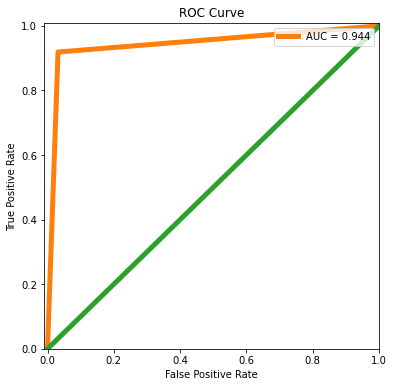

In [ ]:
# Plotting the ROC curve 
plt.figure(figsize = [6,6])
plot_roc_curve(fpr,tpr,roc_auc)
plt.show()

We have applied SMOTE and ADASYN on imbalanced data and build different models to check the evaluation metric. XGBoost is found to be the best model after applying ADASYN. Achieved ROC AUC score of 0.944 which seems to be satisfactory. Most Importantly, Recall is coming around 0.92 which is very important in detecting fraud transactions.

## 9. Conclusive Remarks

We have build Logistic Regression, Decision Tree, Random Forest and XGBoost model based on the PCA transformed raw data (imbalanced data). 
As dataset was not balanced, we have applied oversampling balancing techniques like SMOTE & ADASYN to balance the data.
After balacing the data, we have applied Logistic regression, Decision Tree, Random Forest and XGBoost to find the best model in detecting the frud transactions.
In this use case, Accuracy was not a concerning Evaluation metrics and we focussed more on ROC AUC Score and Recall.
We finally able to build our best fit model (XGBoost) which are able to predict test data extremely well (Achieved ROC AUC Score of 0.944) and detect fraud transactions (Achieved Recall of 0.92) as well.